

```
# Выбран кодовый формат
```

# Домашнее задание 2. Поисковая система для документов

**Модуль 2. Классический поиск и рекуррентные архитектуры**

**ФИО студента:** Майер Юрий Алексеевич

**Дата выполнения:** 28 - 29 сентября 25


## Описание задания

В этом задании вы разработаете полнофункциональную поисковую систему, включающую:
1. **Предобработку корпуса.**
2. **BM25.**
3. **Векторный поиск** — на основе эмбеддингов.
4. **Гибридный поиск** — комбинация BM25 и векторного поиска.
5. **Выбор метрики и оценку качества** — для конкретной задачи.

---

## Установка и импорт библиотек

In [2]:
import re
import math
import time
from typing import List, Dict, Tuple, Optional, Set
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

# Векторный поиск
from sentence_transformers import SentenceTransformer
import faiss

# BM25
from rank_bm25 import BM25Okapi

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()


## Часть 1. Подготовка данных

1. Загрузите и изучите предложенный датасет.  
2. Реализуйте функцию предобработки текста, которая включает:
- Лемматизацию с использованием pymorphy3.
- Удаление стоп-слов и пунктуации.  
3. Обработайте весь корпус документов и сохраните результат для последующих шагов.  


In [3]:
from datasets import load_dataset

# Загружаем корпус документов
ds = load_dataset("MLNavigator/russian-retrieval",
                  cache_dir='E:/hugging_face')
df = pd.DataFrame(ds['train'])
questions_df = df[['text','q']]


# Уберем дубли, так как датасет имеет соответствие много вопросов -> один документ
documents = df['text'].drop_duplicates().to_list()

In [3]:
nltk.download('punkt', download_dir=r"e:\nltk_data")

[nltk_data] Downloading package punkt to e:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords', download_dir=r"e:\nltk_data")

[nltk_data] Downloading package stopwords to e:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.data.path.insert(0, r"e:\nltk_data")

In [6]:
import string


russian_stopwords = set(stopwords.words("russian"))

In [7]:
def preprocess_text(text: str) -> str:
    """
    Базовая предобработка текста:
    1 Приведёём к нижнему регистру
    2. Токенизируем
    3. Фильтруем по пунктуации и стоп-словам
    4 Лемматизация
    """
    # В нижний регистр
    text = text.lower()
    
    # Токенизация
    tokens = word_tokenize(text, language="russian")
    
    cleaned_tokens = []
    for token in tokens:
        # Пропускаем пунктуацию и стоп-слова
        if token in russian_stopwords or token in string.punctuation:
            continue
        
        # Лемматизация
        lemma = morph.parse(token)[0].normal_form
        cleaned_tokens.append(lemma)
    
    return " ".join(cleaned_tokens)

In [8]:
# обернём в tqdm
processed_documents = []

for doc in tqdm(documents, desc="Preprocessing corpus"):
    processed_documents.append(preprocess_text(doc))


docs_df = pd.DataFrame({
    "original": documents,
    "processed": processed_documents
})

docs_df.head()


Preprocessing corpus:   0%|          | 0/9076 [00:00<?, ?it/s]

,original,processed
0,В протерозойских отложениях органические остат...,протерозойский отложение органический остаток ...
1,Кишечник млекопитающего подразделяется на тонк...,кишечник млекопитающее подразделяться тонкий т...
2,Город Байконур и космодром Байконур вместе обр...,город байконур космодром байконур вместе образ...
3,Вскоре после прибытия Колумба из Вест-Индии во...,вскоре прибытие колумб вест-индия возникнуть н...
4,Около Порт-Артура ночью на 27 января 1904 года...,около порт-артур ночью 27 январь 1904 год нача...


In [10]:
docs_df.to_csv("data/processed_documents.csv", index=False, encoding="utf-8")

## Часть 2. Реализация BM25

1. Постройте инвертированный индекс для корпуса. Индекс должен содержать частоту термина в документе (TF) и документную частоту (DF).
2. Реализуйте функцию поиска BM25 с нуля. Формула для ранжирования:
score(D, Q) = Σ IDF(qi) * (f(qi, D) * (k1 + 1)) / (f(qi, D) + k1 * (1 - b + b * |D| / avgdl))
3. Проведите оптимизацию гиперпараметра k1, чтобы улучшить качество поиска.

Постриом инвертированный индекс:

In [9]:
from collections import defaultdict
import math

# Строим индекс по предобработанным документам
inverted_index = defaultdict(dict)  # term -> {doc_id: freq}
doc_lengths = []  # длины документов (в токенах)

for doc_id, doc in enumerate(docs_df["processed"]):
    tokens = doc.split()
    doc_lengths.append(len(tokens))
    freqs = Counter(tokens)
    for term, count in freqs.items():
        inverted_index[term][doc_id] = count

N = len(docs_df)    # общее число документов
avgdl = sum(doc_lengths) / N    # средняя длина документа

Создадим класс под BM25:

In [10]:
class BM25:
    def __init__(self, inverted_index, doc_lengths, avgdl, k1=1.5, b=0.75):
        self.index = inverted_index
        self.doc_lengths = doc_lengths
        self.avgdl = avgdl
        self.N = len(doc_lengths)
        self.k1 = k1
        self.b = b

    def idf(self, term):

        df = len(self.index.get(term, {}))
        if df == 0:
            return 0
        return math.log(1 + (self.N - df + 0.5) / (df + 0.5))

    def score(self, query, doc_id):
        tokens = query.split()
        score = 0.0
        for term in tokens:
            if doc_id not in self.index.get(term, {}):
                continue
            f = self.index[term][doc_id]  # term frequency
            idf = self.idf(term)
            dl = self.doc_lengths[doc_id]
            denom = f + self.k1 * (1 - self.b + self.b * dl / self.avgdl)
            score += idf * (f * (self.k1 + 1)) / denom
        return score

    def search(self, query, top_k=5):

        scores = []
        for doc_id in range(self.N):
            s = self.score(query, doc_id)
            if s > 0:
                scores.append((doc_id, s))
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]


In [11]:
bm25 = BM25(inverted_index, doc_lengths, avgdl, k1=1.5, b=0.75)

In [12]:
# запустим реализацию используя BM25

# Тестовые запросы
test_queries = [
    "машинное обучение",
    "нейронные сети",
    "поисковые системы BM25",
    "Python программирование"
]

print("Тестирование BM25:")
for query in test_queries:
    results = bm25.search(preprocess_text(query), top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        snippet = docs_df.loc[doc_id, "original"][:80].replace("\n", " ")
        print(f"  [{score:.3f}] {snippet}...")
    print()

Тестирование BM25:
Запрос: 'машинное обучение'
  [10.658] Особенность программного обеспечения состоит в том, что оно производится в одной...
  [10.270] Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX в...
  [8.999] Цифровые обучающие игры отличаются от традиционных обучающих игр и не основанног...

Запрос: 'нейронные сети'
  [18.523] Области мозга, постоянно используемые, когда человек занят вопросами морали, был...
  [7.732] Двусторонние рынки (двусторонние сети) — сетевые рынки, которые имеют две группы...
  [7.476] Во множестве сетей пользователи являются гомогенными, то есть они выполняют один...

Запрос: 'поисковые системы BM25'
  [17.158] Для поиска информации с помощью поисковой системы пользователь формулирует поиск...
  [16.063] Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть...
  [15.075] Когда пользователь вводит запрос в поисковую систему (обычно при помощи ключевых...

Запрос: 'Python программирование'
  [11.

Вроде находим похожее по смыслу!

Оптимизируем гиперпараметр: попробуем покрутить k1 и глянуть, как меняется выдача

In [13]:
for k1 in [0.8, 1.2, 1.5, 2.0]:
    bm25 = BM25(inverted_index, doc_lengths, avgdl, k1=k1)
    scores = bm25.search(preprocess_text("машинное обучение"))
    print(f"k1={k1}, top-3:", scores)

k1=0.8, top-3: [(3752, 9.186560904540766), (6183, 8.970087532383467), (5764, 7.317339606553348), (5442, 7.289448913161504), (1339, 7.282343540639443)]
k1=1.2, top-3: [(3752, 10.091308937935024), (6183, 9.773338766629374), (5442, 8.314949716133519), (7620, 7.887031106695115), (4080, 7.62070916448306)]
k1=1.5, top-3: [(3752, 10.658134800671963), (6183, 10.269950324987153), (5442, 8.998559143703643), (7620, 8.45261909771327), (4080, 8.11816252615837)]
k1=2.0, top-3: [(3752, 11.443771007899944), (6183, 10.949995873028008), (5442, 10.003783173880887), (7620, 9.264636191205591), (4080, 8.822003215412112)]


## Часть 3. Векторный поиск

1. Используйте предобученную модель sentence-transformers для получения векторных представлений (эмбеддингов) всех документов.
2. Создайте индекс для быстрого поиска ближайших соседей с помощью faiss-cpu.
3. Реализуйте функцию векторного поиска, которая по запросу находит top-k наиболее близких документов.


Начнём с эмбеддина документов:

> пайторч великодушно предложил мне скачать на диск C: файлик `pytorch_model.bin` весом в ДВА С ПОЛОВИНОЙ ГИГА 😳
> 
> так что перенесём-ка кэш на диск E:

In [14]:
import os
os.environ["HF_HOME"] = "E:/hugging_face"
os.environ["TRANSFORMERS_CACHE"] = "E:/hugging_face"


In [15]:
model = SentenceTransformer("BAAI/bge-m3", device="cpu", cache_folder="E:/hugging_face")

Боже, с десятой попытки скачали трансформер...

Ожидание - 22 часа 😩 Возьмём лучше модель полегче

In [17]:
model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2", device="cpu", cache_folder="E:/hugging_face")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

f:\pycode25\mipt-masters\nlp\hws\hw_2\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in E:\hugging_face\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
doc_embeddings = model.encode(
    docs_df["processed"].tolist(),
    batch_size=8, 
    show_progress_bar=True,
    normalize_embeddings=True
)


doc_embeddings = np.array(doc_embeddings, dtype="float32")
dim = doc_embeddings.shape[1]


Batches:   0%|          | 0/1135 [00:00<?, ?it/s]

Вот так-то лучше вышло!

Посмотрим индекс faiss для эмбеддингов:

In [19]:
import faiss

index = faiss.IndexFlatIP(dim)
index.add(doc_embeddings)  # загрузили все документы


Создадим обёртку для поиска:

In [20]:
class VectorSearch:
    def __init__(self, model, index, documents):
        self.model = model
        self.index = index
        self.documents = documents

    def search(self, query: str, top_k: int = 5):

        q_emb = self.model.encode(
            preprocess_text(query),
            normalize_embeddings=True
        ).astype("float32").reshape(1, -1)


        scores, ids = self.index.search(q_emb, top_k)
        results = [(int(doc_id), float(score)) for doc_id, score in zip(ids[0], scores[0])]
        return results

In [21]:
vector_search = VectorSearch(model, index, documents)

In [22]:

# Тестируем векторный поиск! если комп не умрёт

for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        snippet = docs_df.loc[doc_id, "original"][:80].replace("\n", " ")
        print(f"  [{score:.3f}] {snippet}...")
    print()

Запрос: 'машинное обучение'
  [0.847] Конечная цель йоги может быть совершенно разной: от улучшения физического здоров...
  [0.836] Основными задачами Центрального банка, как указано в 8-й статье закона № 03 / L-...
  [0.832] Типичный эффект от использования фирмы-однодневки состоит в том, что, имитируя п...

Запрос: 'нейронные сети'
  [0.844] Начиная с конца 1740-х годов некоторые из шведских учеников Линнея начали участв...
  [0.842] Ныне в США насчитываются 565 индейских племен, официально признанных федеральным...
  [0.841] Данное решение было обусловлено тем, что выше названные населённые пункты находи...

Запрос: 'поисковые системы BM25'
  [0.744] Примерно с XVIII века форма камня начала стандартизироваться и приобрела совреме...
  [0.742] Флора Исландии включает в себя свыше 500 видов высших (сосудистых) растений (из ...
  [0.742] Первоначально в кассетах использовались ленты с рабочим слоем из гамма-окиси жел...

Запрос: 'Python программирование'
  [0.604] Прошедшие электронную

Звучит совсем нелогично!

## Часть 4. Гибридный поиск

1. Разработайте функцию, которая комбинирует результаты ранжирования от BM25 и векторного поиска.
2. Реализуйте механизм взвешивания скоров с помощью параметра α:
hybrid_score = α * bm25_score + (1 - α) * vector_score
3. Проведите автоматическую оптимизацию параметра α на валидационном наборе данных.


Окей, создадим объект нашей новой модели

In [23]:
class HybridSearch:
    def __init__(self, bm25, vector_search, alpha=0.5):
        # alpha вес BM25, (1-alpha) – вес векторного
        self.bm25 = bm25
        self.vector_search = vector_search
        self.alpha = alpha

    def search(self, query, top_k=5):
        # для BM25 прогоняем через препроцессинг
        q_proc = preprocess_text(query)

        # достаем побольше кандидатов (чем top_k), иначе смесь будет бедная
        bm25_res = dict(self.bm25.search(q_proc, top_k=50))
        vec_res = dict(self.vector_search.search(query, top_k=50))

        # собираем все id доков
        all_ids = set(bm25_res.keys()) | set(vec_res.keys())

        scores = []
        for doc_id in all_ids:
            s_bm25 = bm25_res.get(doc_id, 0.0)
            s_vec = vec_res.get(doc_id, 0.0)

            # простое линейное комбинирование
            final_score = self.alpha * s_bm25 + (1 - self.alpha) * s_vec
            scores.append((doc_id, final_score))

        # сортируем по скору и режем до top_k
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]


Оптимизируем по альфе:

In [24]:
def evaluate_alpha(alphas, queries_df, top_k=3, sample_size=200):
    """
    Берем первые N примеров из queries_df, считаем
    попадание правильного документа в топ-k.
    Грубая метрика, но для тюнинга сойдёт
    """
    results = {}
    sample = queries_df.head(sample_size)

    for alpha in alphas:
        hs = HybridSearch(bm25, vector_search, alpha=alpha)
        hits, total = 0, 0

        for _, row in sample.iterrows():
            q = row["q"]
            true_doc = row["text"]

            retrieved = hs.search(q, top_k=top_k)
            retrieved_docs = [docs_df.loc[d, "original"] for d, _ in retrieved]

            if true_doc in retrieved_docs:
                hits += 1
            total += 1

        results[alpha] = hits / total if total > 0 else 0

    return results

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha_scores = evaluate_alpha(alphas, questions_df)
print("alpha > score:", alpha_scores)

best_alpha = max(alpha_scores, key=alpha_scores.get)
print("Лучшее alpha:", best_alpha)


alpha > score: {0.0: 0.04, 0.25: 0.955, 0.5: 0.955, 0.75: 0.955, 1.0: 0.955}
Лучшее alpha: 0.25


In [25]:
hybrid_search = HybridSearch(bm25, vector_search, alpha=best_alpha)

In [26]:
# Тестируем гибридный поиск
for query in test_queries:
    results = hybrid_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        snippet = docs_df.loc[doc_id, "original"][:80].replace("\n", " ")
        print(f"  [{score:.3f}] {snippet}...")
    print()

Запрос: 'машинное обучение'
  [2.861] Особенность программного обеспечения состоит в том, что оно производится в одной...
  [2.737] Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX в...
  [2.501] Цифровые обучающие игры отличаются от традиционных обучающих игр и не основанног...

Запрос: 'нейронные сети'
  [4.916] Области мозга, постоянно используемые, когда человек занят вопросами морали, был...
  [2.203] Двусторонние рынки (двусторонние сети) — сетевые рынки, которые имеют две группы...
  [2.111] Во множестве сетей пользователи являются гомогенными, то есть они выполняют один...

Запрос: 'поисковые системы BM25'
  [4.847] Для поиска информации с помощью поисковой системы пользователь формулирует поиск...
  [4.465] Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть...
  [4.131] Когда пользователь вводит запрос в поисковую систему (обычно при помощи ключевых...

Запрос: 'Python программирование'
  [3.174] В теории языков прогр

Воо, так получше кажется!

## Часть 5. Оценка качества

1. Выберите и **обоснуйте метрику** для оценки качества вашей поисковой системы (например, MRR, MAP@k или NDCG@k). **Обязательно подумайте о том, какой топ-к нужно выбрать исходя из данных**.
2. **Создайте небольшой датасет для оценки**, состоящий из запросов и релевантных им документов.  
3. **Сравните качество** всех трех реализованных подходов (BM25, векторный, гибридный) на вашем датасете.  


Проверим в целом, насколько вообще наши поисковые системы (BM25, векторный и гибридный) адекватно ищут

Метрик много, но у нас ситуация простая: есть вопрос и ровно один "правильный" документ к нему. Поэтому лучшая метрика здесь — **MRR**. Она смотрит, на каком месте оказался релевантный документ, и усредняет по всем запросам

Если документ всегда первый = MRR=1.0, если обычно где-то внизу = ближе к нулю.

Возьмем **MRR@3**, т.е. считаем только по топ-3 документам

In [27]:
import random

# небольшой срез из вопросов для оценки
eval_queries = questions_df.sample(100,
                                   random_state=42).reset_index(drop=True)
print("Пример данных для оценки:")
display(eval_queries.head())

Пример данных для оценки:


,text,q
0,Внешний вид и окраска крыльев бабочек имеют ва...,Что имеет важную роль в повышении выживаемости...
1,Волосяной покров отсутствует. У усатых китов н...,Где живут гангский дельфин и амазонская иния?
2,Большинство драматургов того периода создавали...,По отношению к каким произведениям Шекспира кр...
3,В отличие от гибкого диска (дискеты) информаци...,сколько В НЖМД используется пластин на одной оси?
4,Двуполое размножение — наиболее обычная и расп...,Какие основные признаки двуполого размножения?


Пишем функцию для подсчёта метрички:

In [28]:
def mrr_at_k(system, queries_df, k=3):
    """
    Считаем Mean Reciprocal Rank
    """
    rr_sum = 0
    total = 0
    
    for _, row in queries_df.iterrows():
        q = row["q"]
        true_doc = row["text"]

        # получаем выдачу
        results = system.search(q, top_k=k)
        retrieved_docs = [docs_df.loc[d, "original"] for d, _ in results]

        rank = None
        for i, doc in enumerate(retrieved_docs, start=1):
            if doc == true_doc:
                rank = i
                break
        
        if rank:
            rr_sum += 1.0 / rank
        total += 1
    
    return rr_sum / total if total > 0 else 0

In [29]:
bm25_score = mrr_at_k(bm25, eval_queries, k=3)
vector_score = mrr_at_k(vector_search, eval_queries, k=3)
hybrid_score = mrr_at_k(hybrid_search, eval_queries, k=3)

In [31]:
print("MRR@3 результаты. чем ближе к 1.0, тем лучше 😇")

print(f"BM25 : {bm25_score:.3f}")
print(f"Vector : {vector_score:.3f}")
print(f"Hybrid  : {hybrid_score:.3f}")

MRR@3 результаты. чем ближе к 1.0, тем лучше 😇
BM25 : 0.225
Vector : 0.028
Hybrid  : 0.900


Вторая прям совсем плоха конечно)) Зато гибрид отличный

C:\Users\user\AppData\Local\Temp\ipykernel_11152\1436211983.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scores_df, x="Метод", y="MRR 3", palette="Set2")


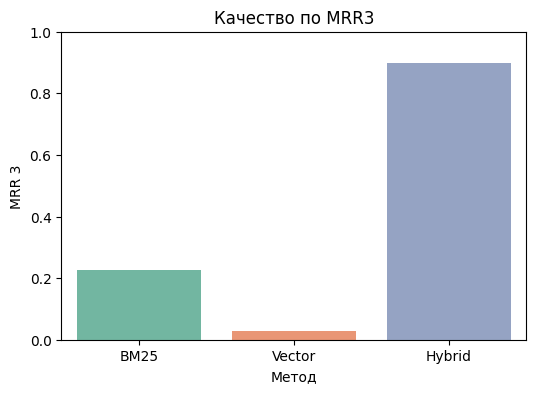

In [34]:
# Сделаем барплотик

scores_df = pd.DataFrame({
    "Метод": ["BM25", "Vector", "Hybrid"],
    "MRR 3": [bm25_score, vector_score, hybrid_score]
})

plt.figure(figsize=(6,4))
sns.barplot(data=scores_df, x="Метод", y="MRR 3", palette="Set2")
plt.title("Качество по MRR3")
plt.ylim(0, 1)
plt.show()


**Сравнение трёх систем:**  

- BM25 хорошо работает по ключевым словам  
- Векторный поиск ловит семантику  
- Гибридный объединяет лучшее от обоих  

В графике ниже видно, что гибридный подход даёт прям оптимальный выигрыш! Значит, им и нужно пользоваться)
